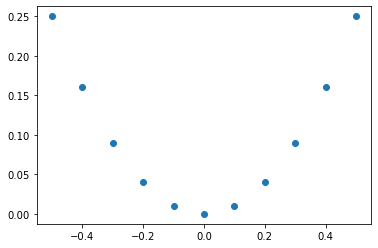

In [32]:
import matplotlib.pyplot as plt

# using function in the form y = f(x)
# y = x^2
def calculate(x):
    return x**2

inputs = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
outputs = [calculate(x_val) for x_val in inputs]

plt.scatter(x=inputs, y=outputs)
# plt.plot(inputs, outputs)
plt.show()

In [33]:
import numpy as np
import random

def generate_real_samples(num_points):
	x_vals = [random.randint(-0.5, 0.5) for i in range(num_points)]
	final_x_vals = np.array([[x_vals[i], x_vals[i] ** 2] for i in range(len(x_vals))])

	y_labels = np.array([[1] for i in range(len(final_x_vals))])

	return final_x_vals, y_labels 

def generate_fake_samples(generator, latent_dim, n):
	# generates latent space of x values
	x_input = generate_latent_vector_space(latent_dim, n)
	# use generator network to get outputs for fake data (predict the y values)
	x_fake_data = generator.predict(x_input)

	y_labels = np.array([[1] for i in range(len(x_input))])

	return x_fake_data, y_labels

In [34]:
# Discriminator Model
# model has to take a sample from the generative model and output a classification (if sample is real or fake)
import tensorflow as tf

# neural network structure
#   input  layer (2 nodes)
# 1 hidden layer (25 nodes) - ReLu activation function - He weight initialization
#   output layer (1 node)   - Sigmoid activation function

def discriminator_model(num_inputs=2):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=25, activation = 'relu', kernel_initializer='he_uniform', input_dim=num_inputs))
    model.add(tf.keras.layers.Dense(units=1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

model = discriminator_model()
model.summary()
# keras.utils.plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 25)                75        
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 26        
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [35]:
# training discriminator
def train_discriminator_model(model, num_epochs=1000, batch_size=128):
    half_batch = batch_size // 2
    for i in range(num_epochs):
        # generate and train on real batch and update model
        x_real, y_real = generate_real_samples(num_samples=half_batch)
        x_real = np.array(x_real)
        y_real = np.array(y_real)
        model.train_on_batch(x_real, y_real)

        # generate and train on fake batch and update model
        x_fake, y_fake = generate_fake_samples(num_samples=half_batch)
        x_fake = np.array(x_fake)
        y_fake = np.array(y_fake)
        model.train_on_batch(x_fake, y_fake)

        # evaluate model
        _, accuracy_real = model.evaluate(x_real, y_real, verbose = 0)
        _, accuracy_fake = model.evaluate(x_fake, y_fake, verbose = 0)

        print('[iteration {}   real_data_accuracy {}   fake_data_accuracy {}]'.format(i + 1, accuracy_real, accuracy_fake))

model = discriminator_model()
train_discriminator_model(model)

In [36]:
def generator_model(latent_dim, num_outputs=2):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(tf.keras.layers.Dense(num_outputs, activation='linear'))

    return model

In [37]:
latent_space_vector_dims = 5
model = generator_model(latent_space_vector_dims)

model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 15)                90        
_________________________________________________________________
dense_37 (Dense)             (None, 2)                 32        
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________


In [49]:
# GENERATE LATENT VECTOR SPACE
def generate_latent_vector_space(latent_space_dimensions, num_vectors):
    x_vectors = np.random.randn(latent_space_dimensions * num_vectors)

    x_vectors = x_vectors.reshape(num_vectors, latent_space_dimensions)
    return x_vectors

latent_space_dimensions = 5
model = generator_model(latent_space_dimensions)
generate_fake_samples(model, latent_space_dimensions, 100)

In [ ]:
def GAN(generator_model, discriminator_model):
    discriminator_model.trainable = False

    model = tf.keras.Sequential()

    model.add(generator_model)
    model.add(discriminator_model)

    model.compile(loss='binary_crossentropy', optimizer='adam')

    return model

latent_space_dimensions = 5

discriminator_network = discriminator_model()
generator_network = generator_model(latent_space_dimensions)

gan_network = GAN(generator_network, discriminator_network)
gan_network.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 2)                 122       
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 101       
Total params: 223
Trainable params: 122
Non-trainable params: 101
_________________________________________________________________


In [40]:
def train_GAN(gan_model, latent_space_dimensions, num_epochs=10000, batch_size=128):
    for i in range(num_epochs):
        x_latent_vectors = generate_latent_vector_space(latent_space_dimensions, batch_size)
        y_labels = [[1] for i in range(batch_size)]

        gan_model.train_on_batch(x_latent_vectors, y_labels)

In [89]:
def train(generator_model, discriminator_model, gan_model, latent_space_dimensions, num_epochs=10000, batch_size=128, evaluation_buffer=1000):
    half_batch = batch_size // 2

    for i in range(num_epochs):
        x_real, y_real = generate_real_samples(half_batch)
        x_fake, y_fake = generate_fake_samples(generator_model, latent_space_dimensions, half_batch)

        discriminator_model.train_on_batch(x_real, y_real)
        discriminator_model.train_on_batch(x_fake, y_fake)

        x_latent_space = generate_latent_vector_space(latent_space_dimensions, batch_size)
        y_labels = np.array([[1] for i in range(batch_size)])

        gan_model.train_on_batch(x_latent_space, y_labels)

        if (i + 1) % evaluation_buffer == 0 or i == 0:
            evaluate_generator(generator_model, latent_space_dimensions, discriminator_model, i)
        if (i + 1) == 10000:
            generator_model.save('./models/generator_model')
            discriminator_model.save('./models/discriminator_model')
            gan_model.save('./models/GAN_model')

In [84]:
def evaluate_generator(generator, latent_space_dimensions, discriminator, epoch_number, num_samples=100):
    x_real, y_real = generate_real_samples(num_samples)
    _, accuracy_real_data = discriminator.evaluate(x_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(generator, latent_space_dimensions, num_samples)
    _, accuracy_fake_data = discriminator.evaluate(x_fake, y_fake, verbose=0)

    print('[ EPOCH {} REAL_DATA {} FAKE_DATA {} ]'.format(epoch_number, accuracy_real_data, accuracy_fake_data))

    plt.scatter(x_real[:, 0], x_real[:, 1], color='blue')
    plt.scatter(x_fake[:, 0], x_fake[:, 1], color='limegreen')
    plt.show()

[ EPOCH 0 REAL_DATA 1.0 FAKE_DATA 0.0 ]


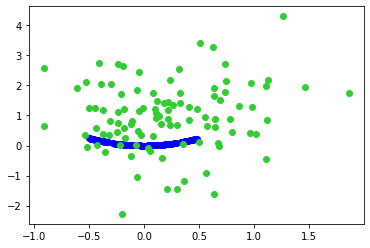

[ EPOCH 999 REAL_DATA 0.6100000143051147 FAKE_DATA 0.6499999761581421 ]


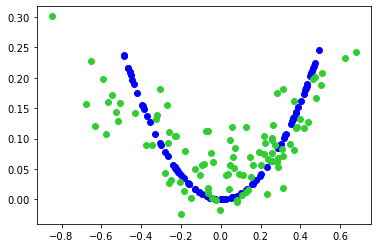

[ EPOCH 1999 REAL_DATA 0.3700000047683716 FAKE_DATA 0.5 ]


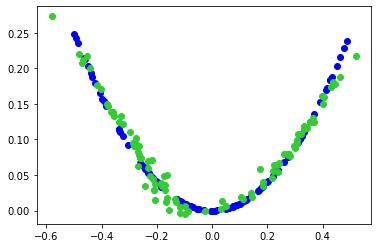

[ EPOCH 2999 REAL_DATA 0.5199999809265137 FAKE_DATA 0.5699999928474426 ]


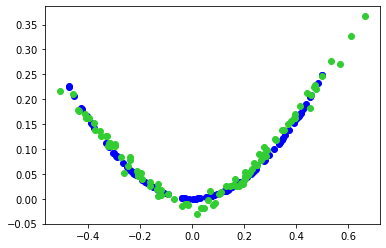

[ EPOCH 3999 REAL_DATA 0.6000000238418579 FAKE_DATA 0.36000001430511475 ]


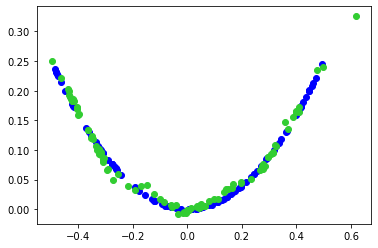

[ EPOCH 4999 REAL_DATA 0.6100000143051147 FAKE_DATA 0.3199999928474426 ]


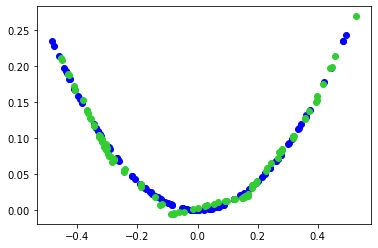

[ EPOCH 5999 REAL_DATA 0.5199999809265137 FAKE_DATA 0.5299999713897705 ]


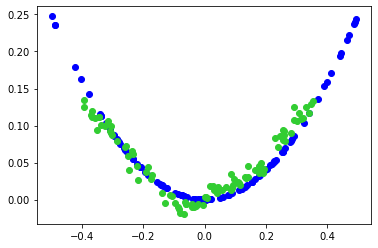

[ EPOCH 6999 REAL_DATA 0.44999998807907104 FAKE_DATA 0.5099999904632568 ]


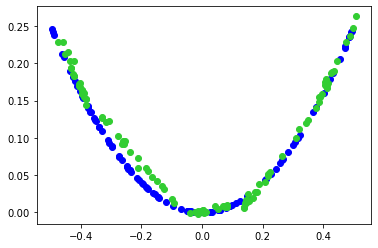

[ EPOCH 7999 REAL_DATA 0.4099999964237213 FAKE_DATA 0.4699999988079071 ]


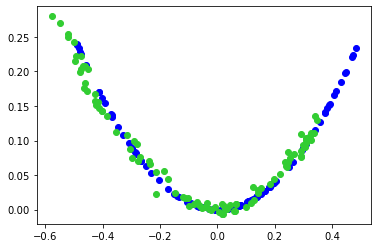

[ EPOCH 8999 REAL_DATA 0.18000000715255737 FAKE_DATA 0.8799999952316284 ]


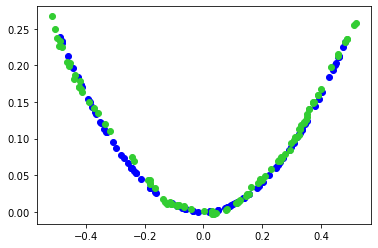

[ EPOCH 9999 REAL_DATA 0.4399999976158142 FAKE_DATA 0.5199999809265137 ]


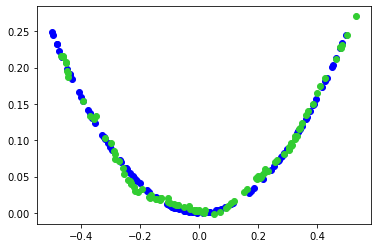

INFO:tensorflow:Assets written to: ./models/generator_model\assets
INFO:tensorflow:Assets written to: ./models/discriminator_model\assets
INFO:tensorflow:Assets written to: ./models/GAN_model\assets


In [90]:
latent_space_vector_dimensions = 5
discriminator = discriminator_model()
generator = generator_model(latent_space_vector_dimensions)

gan_model = GAN(generator, discriminator)

train(generator, discriminator, gan_model, latent_space_vector_dimensions)